<a href="https://colab.research.google.com/github/ksetdekov/DLS/blob/master/01_semester_advanced/11%20pytorch%20homework/%5Bhomework%5Ddense_and_convolutional_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>
<h3 style="text-align: center;"><b>Выполнил Кирилл Сетдеков</b></h3>


В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [2]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
import torch.nn as nn
from torchsummary import summary
from tqdm.notebook import  trange
sns.set(style="darkgrid", font_scale=1.4)
np.random.seed(40)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

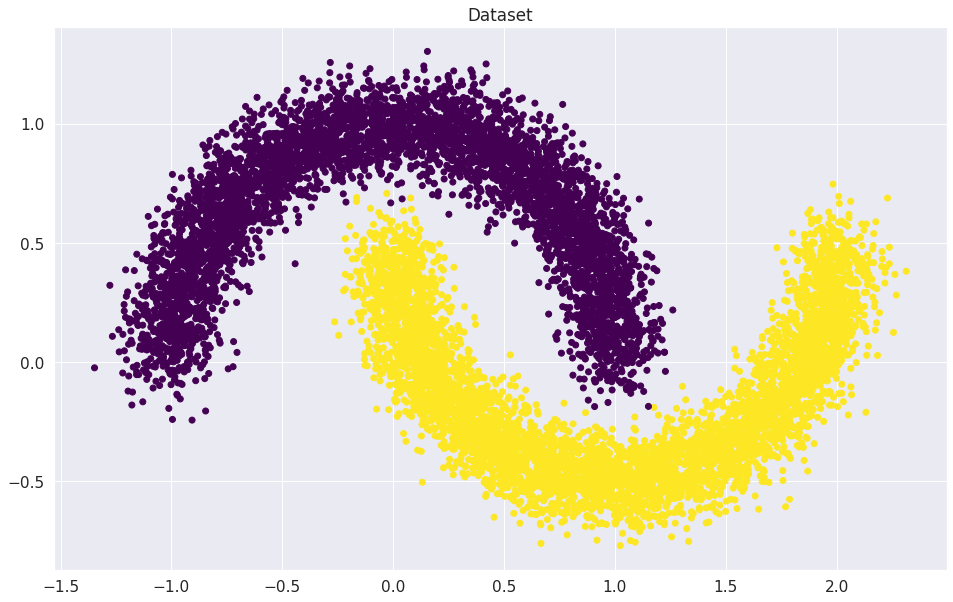

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.tensor(X_train,  dtype=torch.float32) 
y_train_t =  torch.tensor(y_train,  dtype=torch.float32) 
X_val_t =  torch.tensor(X_val,  dtype=torch.float32) 
y_val_t =  torch.tensor(y_val,  dtype=torch.float32) 

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = torch.tensor(np.random.randn(out_features) * np.sqrt(2.0/out_features)) 

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [9]:
print(f'у нас 3 параметра так как {len(linear_regression.weights)} веса и {len(linear_regression.bias_term)} от bias')

у нас 3 параметра так как 2 веса и 1 от bias


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [10]:
m = nn.Sigmoid()

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        # print(f'xbarch size {X_batch.shape}')
        # print(f'output size {outp.shape}')
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  m(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.25
Iteration: 100
Batch accuracy: 0.546875
Iteration: 200
Batch accuracy: 0.7734375
Iteration: 300
Batch accuracy: 0.890625
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.90625
Iteration: 600
Batch accuracy: 0.84375
Iteration: 700
Batch accuracy: 0.859375
Iteration: 800
Batch accuracy: 0.875
Iteration: 900
Batch accuracy: 0.84375

Iteration: 932.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 932

### Визуализируем результаты

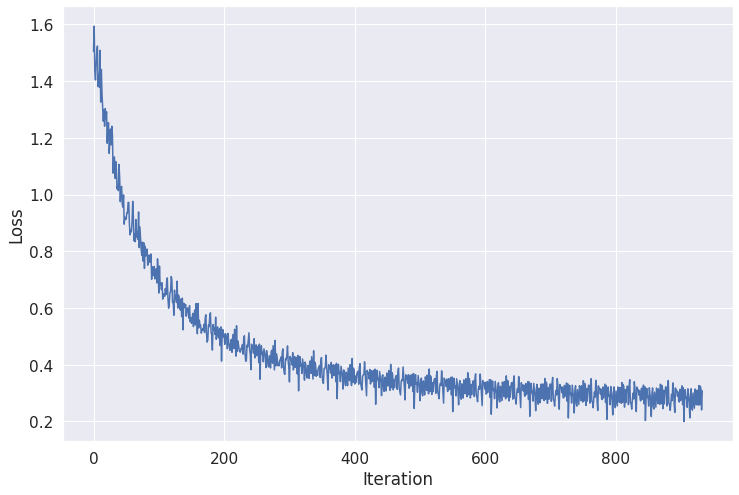

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

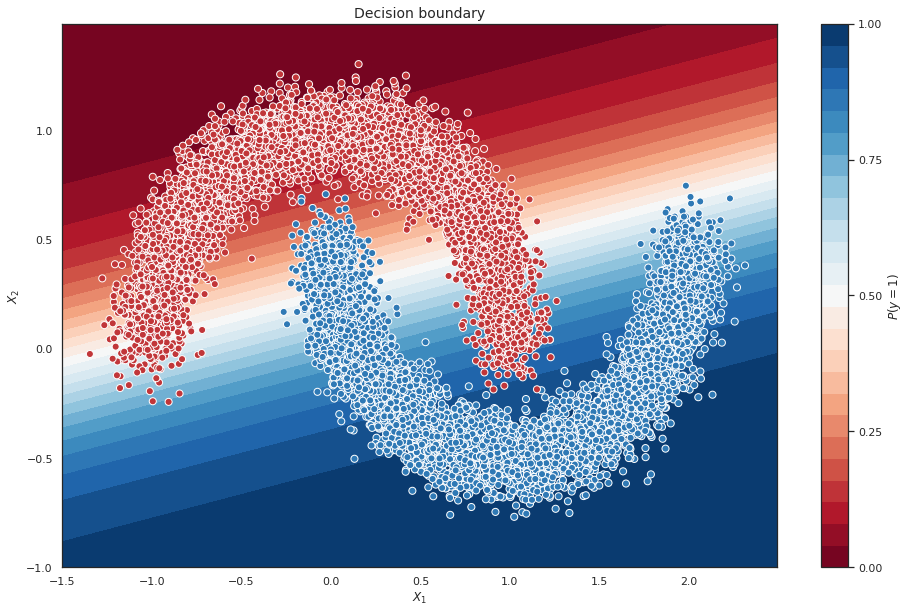

In [13]:

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp =  model(x_batch)
        probabilities =  m(outp)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [15]:

accuracy_score(y_val, predict(val_dataloader, linear_regression))

0.8852

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

0.8852

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [56]:
BATCH_SIZE = 128

In [57]:

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, BATCH_SIZE)
valid_dataloader =  DataLoader(val_dataset, BATCH_SIZE)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


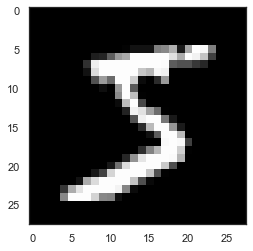

Label: 5


In [58]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [59]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [60]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')  
device

device(type='cuda', index=0)

In [61]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, 10)
)
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [62]:
summary(model, (28,28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 128]         100,480
               ELU-3                 [128, 128]               0
            Linear-4                 [128, 128]          16,512
               ELU-5                 [128, 128]               0
            Linear-6                  [128, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.28
Params size (MB): 0.45
Estimated Total Size (MB): 2.11
----------------------------------------------------------------


In [63]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [65]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  preds[preds==y_batch]
            # print(correct)
            # print(len(correct))
            all =  len(preds)
            # print(f'all count {all}')
            epoch_correct += len(correct)
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8790333333333333
Loader: valid. Accuracy: 0.9215
Epoch: 2
Loader: train. Accuracy: 0.9409333333333333
Loader: valid. Accuracy: 0.9481
Epoch: 3
Loader: train. Accuracy: 0.9592
Loader: valid. Accuracy: 0.9549
Epoch: 4
Loader: train. Accuracy: 0.9683
Loader: valid. Accuracy: 0.9651
Epoch: 5
Loader: train. Accuracy: 0.9740333333333333
Loader: valid. Accuracy: 0.9694
Epoch: 6
Loader: train. Accuracy: 0.97795
Loader: valid. Accuracy: 0.967
Epoch: 7
Loader: train. Accuracy: 0.9809833333333333
Loader: valid. Accuracy: 0.9681
Epoch: 8
Loader: train. Accuracy: 0.9831166666666666
Loader: valid. Accuracy: 0.9694
Epoch: 9
Loader: train. Accuracy: 0.9858833333333333
Loader: valid. Accuracy: 0.9727
Epoch: 10
Loader: train. Accuracy: 0.98645
Loader: valid. Accuracy: 0.9683


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [66]:
elu_accuracy = accuracy["valid"]

In [67]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

# def test_activation_function(activation):

def validate_nn(module=None, epoch_n=10, dl_train=train_dataloader, dl_test=valid_dataloader):

    if module is None:
        model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.Linear(128, 128),
            nn.Linear(128, 10))
    else:
        model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            module,
            nn.Linear(128, 128),
            module,
            nn.Linear(128, 10))

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": dl_train, "valid": dl_test}
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)

    max_epochs = epoch_n
    accuracy = {"train": [], "valid": []}
    for epoch in trange(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = preds[preds == y_batch]
                all = len(preds)
                epoch_correct += len(correct)
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy["valid"]




In [68]:
plain_accuracy = validate_nn(None, 10, train_dataloader, valid_dataloader)
relu_accuracy = validate_nn(nn.ReLU(), 10, train_dataloader, valid_dataloader)
leaky_relu_accuracy = validate_nn(nn.LeakyReLU(), 10, train_dataloader, valid_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8636833333333334
Loader: valid. Accuracy: 0.8821
Epoch: 2
Loader: train. Accuracy: 0.89575
Loader: valid. Accuracy: 0.8999
Epoch: 3
Loader: train. Accuracy: 0.9002833333333333
Loader: valid. Accuracy: 0.901
Epoch: 4
Loader: train. Accuracy: 0.9020833333333333
Loader: valid. Accuracy: 0.9011
Epoch: 5
Loader: train. Accuracy: 0.9042
Loader: valid. Accuracy: 0.9013
Epoch: 6
Loader: train. Accuracy: 0.9054
Loader: valid. Accuracy: 0.9012
Epoch: 7
Loader: train. Accuracy: 0.9069333333333334
Loader: valid. Accuracy: 0.9012
Epoch: 8
Loader: train. Accuracy: 0.908
Loader: valid. Accuracy: 0.9015
Epoch: 9
Loader: train. Accuracy: 0.9090166666666667
Loader: valid. Accuracy: 0.9023
Epoch: 10
Loader: train. Accuracy: 0.9103833333333333
Loader: valid. Accuracy: 0.9037


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8670333333333333
Loader: valid. Accuracy: 0.9195
Epoch: 2
Loader: train. Accuracy: 0.9337
Loader: valid. Accuracy: 0.9451
Epoch: 3
Loader: train. Accuracy: 0.952
Loader: valid. Accuracy: 0.9554
Epoch: 4
Loader: train. Accuracy: 0.9621833333333333
Loader: valid. Accuracy: 0.9607
Epoch: 5
Loader: train. Accuracy: 0.9692
Loader: valid. Accuracy: 0.9672
Epoch: 6
Loader: train. Accuracy: 0.9738833333333333
Loader: valid. Accuracy: 0.9701
Epoch: 7
Loader: train. Accuracy: 0.9775666666666667
Loader: valid. Accuracy: 0.9681
Epoch: 8
Loader: train. Accuracy: 0.98075
Loader: valid. Accuracy: 0.9661
Epoch: 9
Loader: train. Accuracy: 0.9827
Loader: valid. Accuracy: 0.9652
Epoch: 10
Loader: train. Accuracy: 0.9840166666666667
Loader: valid. Accuracy: 0.9666


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.869
Loader: valid. Accuracy: 0.9199
Epoch: 2
Loader: train. Accuracy: 0.9350833333333334
Loader: valid. Accuracy: 0.9469
Epoch: 3
Loader: train. Accuracy: 0.9516
Loader: valid. Accuracy: 0.9548
Epoch: 4
Loader: train. Accuracy: 0.9620333333333333
Loader: valid. Accuracy: 0.9592
Epoch: 5
Loader: train. Accuracy: 0.9682833333333334
Loader: valid. Accuracy: 0.9644
Epoch: 6
Loader: train. Accuracy: 0.9730333333333333
Loader: valid. Accuracy: 0.9671
Epoch: 7
Loader: train. Accuracy: 0.9769833333333333
Loader: valid. Accuracy: 0.9677
Epoch: 8
Loader: train. Accuracy: 0.9800833333333333
Loader: valid. Accuracy: 0.9668
Epoch: 9
Loader: train. Accuracy: 0.9823
Loader: valid. Accuracy: 0.9623
Epoch: 10
Loader: train. Accuracy: 0.98405
Loader: valid. Accuracy: 0.961


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

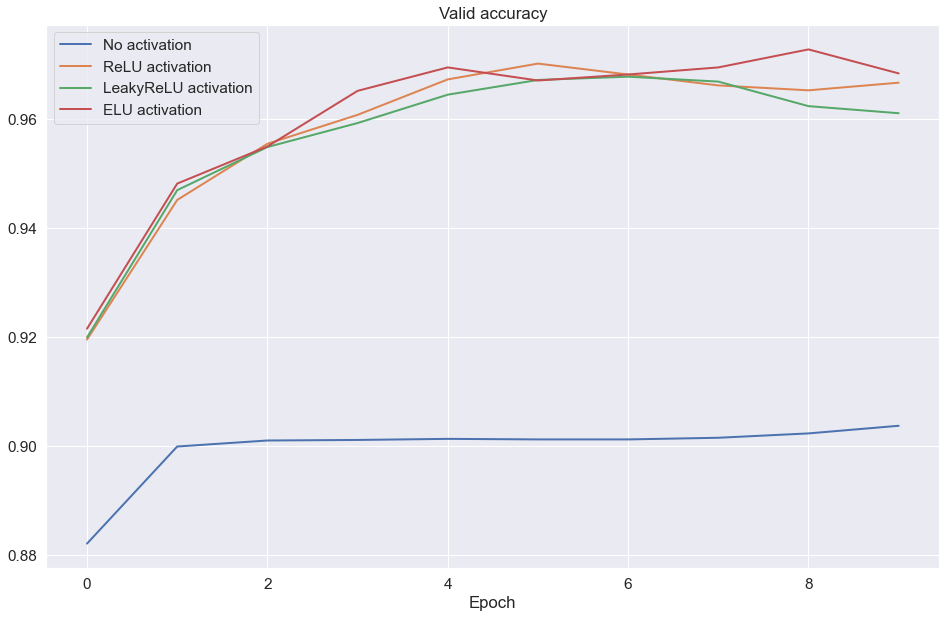

In [69]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** В моей рекализации мо моем запуске - ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [70]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

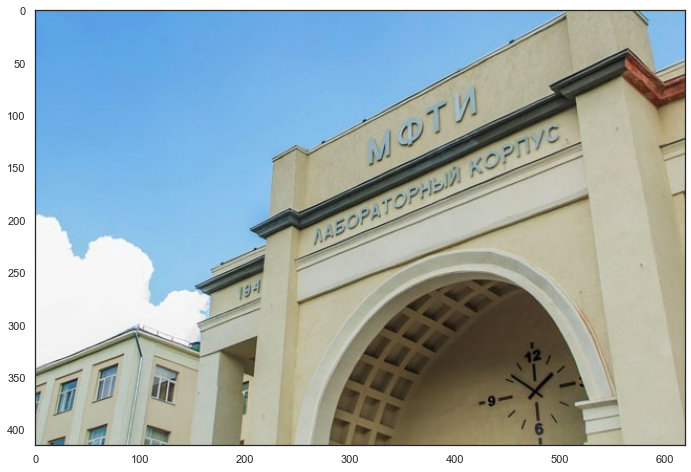

In [71]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [72]:
def draw_kernel(kernel_tensor, kernel_name):
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = torch.tensor(kernel_tensor).reshape(1, 1, 3, 3).type(torch.float32)

    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]  #
    plt.figure(figsize=(12, 8))
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    plt.imshow(result_np)
    plt.title(kernel_name)
    plt.show()

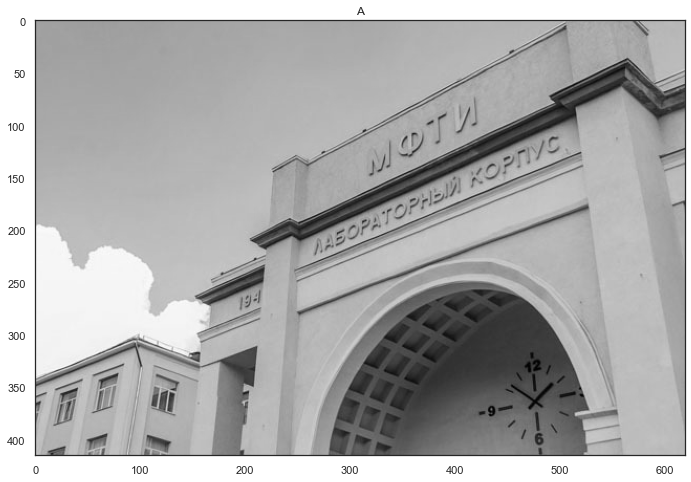

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


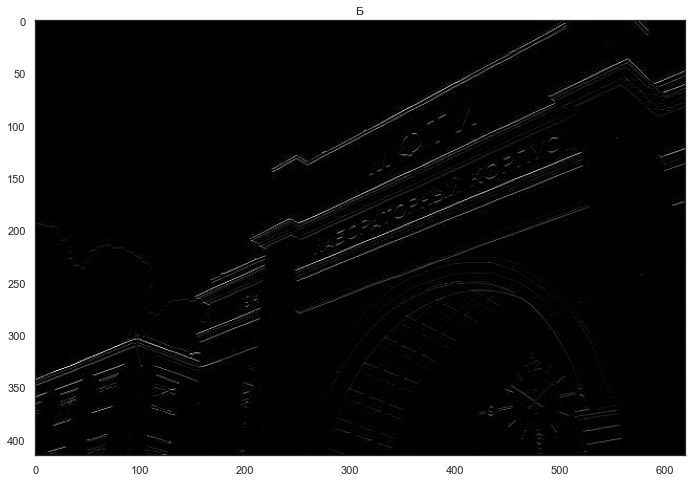

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


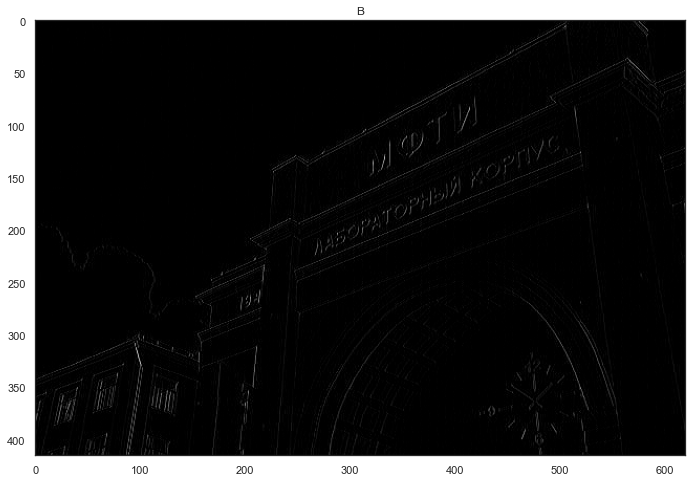

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


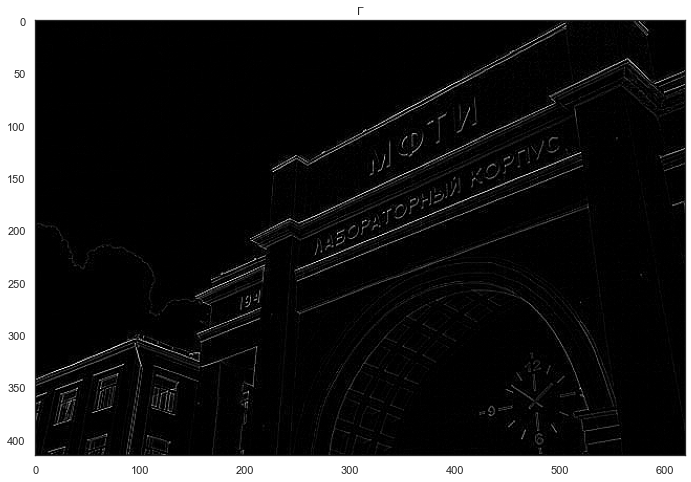

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


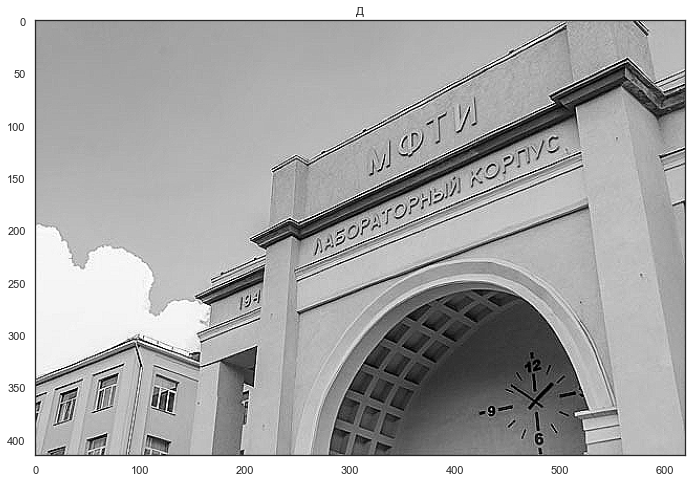

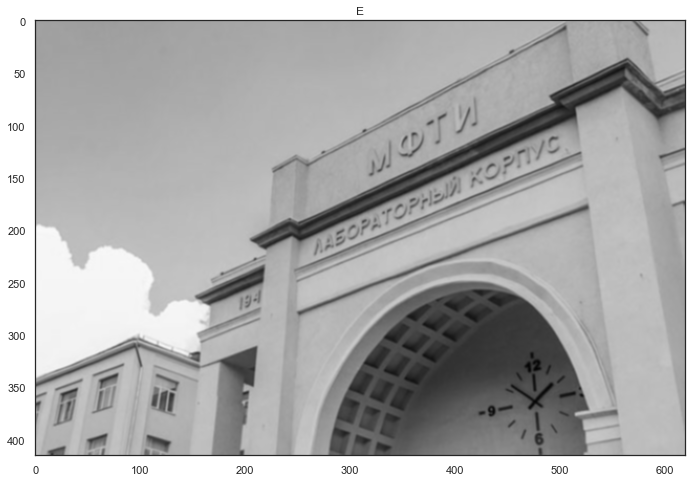

In [73]:
tesnsor_dict = {
    'A': [[0, 0, 0],
          [0, 1, 0],
          [0, 0, 0]],
    'Б':    [[0, 1, 0],
             [0, -2, 0],
             [0, 1, 0]],
    'В':    [[0, 0, 0],
             [1, -2, 1],
             [0, 0, 0]],
    'Г':
    [[0, 1, 0],
     [1, -4, 1],
     [0, 1, 0]],
    'Д':
    [[0, -1, 0],
     [-1, 5, -1],
     [0, -1, 0]],
    'Е':
    [[0.0625, 0.125, 0.0625],
     [0.125, 0.25, 0.125],
     [0.0625, 0.125, 0.0625]]
}

for key, value in tesnsor_dict.items():
    draw_kernel(value, key)

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**
1) Размытие - Е

2) Увеличение резкости - Д

3) Тождественное преобразование - А

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ - Б

6) Выделение границ - Г


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [74]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear( 5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [75]:
net = LeNet()

summary(net.cuda(), (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [76]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [77]:
epoch_n = 10

In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

max_epochs = epoch_n
accuracy = {"train": [], "valid": []}
for epoch in trange(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = preds[preds == y_batch]
            all = len(preds)
            epoch_correct += len(correct)
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

accuracy["valid"]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8621166666666666
Loader: valid. Accuracy: 0.9595
Epoch: 2
Loader: train. Accuracy: 0.9652833333333334
Loader: valid. Accuracy: 0.976
Epoch: 3
Loader: train. Accuracy: 0.9766
Loader: valid. Accuracy: 0.98
Epoch: 4
Loader: train. Accuracy: 0.9822166666666666
Loader: valid. Accuracy: 0.9823
Epoch: 5
Loader: train. Accuracy: 0.9854166666666667
Loader: valid. Accuracy: 0.9832
Epoch: 6
Loader: train. Accuracy: 0.9877666666666667
Loader: valid. Accuracy: 0.9838
Epoch: 7
Loader: train. Accuracy: 0.9895333333333334
Loader: valid. Accuracy: 0.9848
Epoch: 8
Loader: train. Accuracy: 0.9907166666666667
Loader: valid. Accuracy: 0.9852
Epoch: 9
Loader: train. Accuracy: 0.9922333333333333
Loader: valid. Accuracy: 0.9853
Epoch: 10
Loader: train. Accuracy: 0.99335
Loader: valid. Accuracy: 0.986


[0.9595, 0.976, 0.98, 0.9823, 0.9832, 0.9838, 0.9848, 0.9852, 0.9853, 0.986]

In [79]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

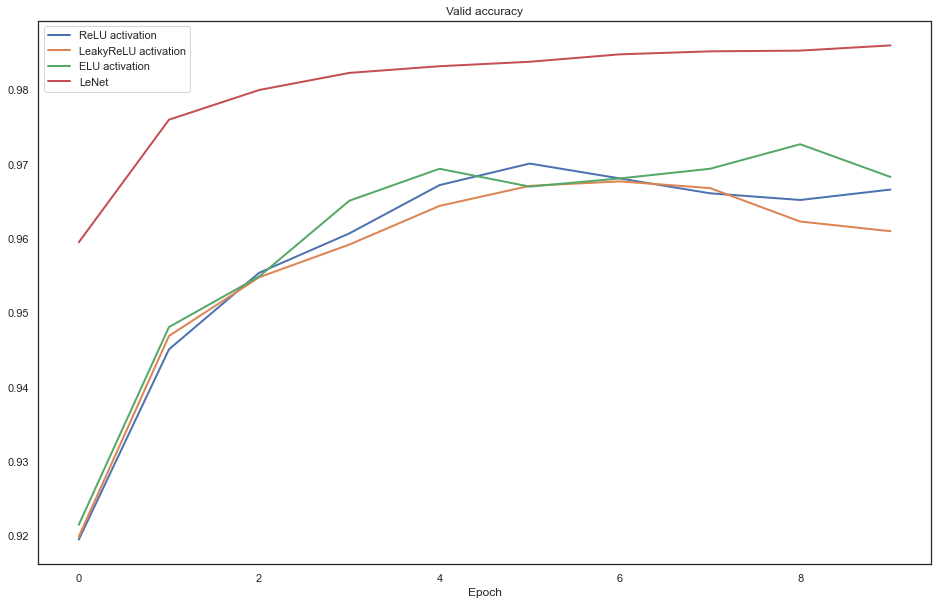

In [80]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [86]:
print(f'lenet accuraty {lenet_accuracy[-1]:.2f}')

lenet accuraty 0.99


**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** Удалось получить с LeNet точность 0.99 (точно 0.986)